# **Optimización de los parámetros de criptografía de curva elíptica mediante dos algoritmos genéticos de inteligencia artificial para transaciones de comercio electrónico de terceros**.

### **Instalación de librerías**

In [1]:
%pip install tinyec
%pip install deap
%pip install ecdsa
%pip install ecc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### **Importación de librerías**

In [2]:
import deap
import random
import matplotlib.pyplot as plt
import os
import copy
import time
import math
import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import secrets

from datetime import datetime
from deap import base, creator, tools, algorithms
from tinyec import ec
from sympy.ntheory import isprime
from sympy import isprime
from secrets import randbelow
from ecdsa import VerifyingKey
from sympy import factorint
from collections import Counter

Se impora el fichero que contiene funciones que se utilizarán durante el proyecto.

In [3]:
import functionext

## **Preprocesamiento y limpieza de los datos**

A continuación se ha importado el excel Online_Retail.xlsx de kaggle.

In [4]:
df = pd.read_excel('Online_Retail.xlsx')
df

,OrderNo,StockCode,Description,Quantity,OrderDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0
...,...,...,...,...,...,...,...
99994,544795,22716,CARD CIRCUS PARADE,12,2011-02-23 13:21:00,0.42,15858.0
99995,544795,22815,CARD PSYCHEDELIC APPLES,12,2011-02-23 13:21:00,0.42,15858.0
99996,544795,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0
99997,544795,22035,VINTAGE CARAVAN GREETING CARD,12,2011-02-23 13:21:00,0.42,15858.0


1. **Resumen de los datos**


Se utilizará el comando `.info()` para imprimir un resumen de la información del DataFrame para ver si se han cargado bien los datos.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderNo      99999 non-null  object        
 1   StockCode    99999 non-null  object        
 2   Description  99700 non-null  object        
 3   Quantity     99999 non-null  int64         
 4   OrderDate    99999 non-null  datetime64[ns]
 5   UnitPrice    99999 non-null  float64       
 6   CustomerID   65084 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.3+ MB


**2. Datos incompletos**

In [6]:
total_nan_values = df.isnull().sum()
total_nan_values

OrderNo            0
StockCode          0
Description      299
Quantity           0
OrderDate          0
UnitPrice          0
CustomerID     34915
dtype: int64

In [7]:
df.dropna(subset=['Description'], inplace=True)
df.dropna(subset=['CustomerID'], inplace=True)

In [8]:
total_nan_values = df.isnull().sum()
total_nan_values

OrderNo        0
StockCode      0
Description    0
Quantity       0
OrderDate      0
UnitPrice      0
CustomerID     0
dtype: int64

**3. Datos Incorrectos o Inconsistentes**

In [10]:
print(min(df['Quantity']), max(df['Quantity']))

-74215 74215


In [11]:
df = df[df['Quantity'] >= 0]

In [12]:
print(min(df['UnitPrice']), max(df['UnitPrice']))

0.0 320.69


## **Creación de la curva elíptica**

In [13]:
def generate_curve():
    def handler(signum, frame):
        raise TimeoutError()

    signal.signal(signal.SIGALRM, handler)

    while True:
        p = functionext.get_prime_for_p()  # Generate a prime number p
        # Generate two random numbers 'a' and 'b' which are coefficients of the elliptic curve. The loop ensures the curve is not singular
        while True:
            a = random.randint(0, p-1)
            b = random.randint(0, p-1)
            if (4*a**3 + 27*b**2) % p != 0 and not functionext.is_singular(a, b, p):
                break
        try:
            signal.alarm(TIMEOUT_SECONDS)
            # Find a base point 'G' on the elliptic curve. The loop ensures the point lies on the curve
            G = functionext.find_generator_point(a, b, p)
            signal.alarm(0)  # Disable the alarm after the critical code has been run
            break  # If no exception was raised, break the outer loop as well.
        except (functionext.NoGeneratorPointException, TimeoutError):
            continue  # If an exception was raised, continue the outer loop to generate new a, b and p.
    n = p - 1  # Rough approximation of the order of the curve.
    h = 1  # Cofactor, defaults to 1
    return (a, b, p, G, n, h)  # Return the parameters as a tuple

## **Cálculo de los parámetros mediante el Algoritmo Genético (GA)**

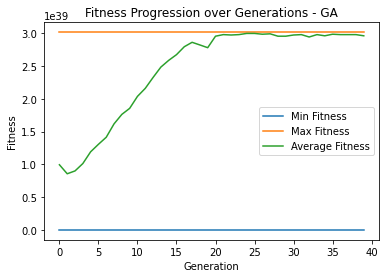

Min 0.0
Max 3.01342826226062e+39
Avg 2.9591865535399474e+39
Std 4.006386590023073e+38
Best individual is [29792324974335347208984898744328375174571084284021957811930160384433097625152, 70923190604869086021029835737694966602857700554744415574540233646491345161877, 115363652634288986792504862230212781565782928051088489855928259115745805412643, (4, 66596526570429524283398440952645772638474736605304808823236056713572805339085), 115363652634288986792504862230212781565782928051088489855928259115745805412642, 1], (3.01342826226062e+39,)


In [177]:
POP_SIZE = 500
CXPB = 0.5
MUTPB = 0.2
NGEN = 40
MULTIPARENT_CXPB = 0.1
ELITISM_RATE = 0.1
BITS_PRIME_SIZE = 256
TIMEOUT_SECONDS = 96000

def customMutation(individual, indpb, mutation_rate):
    degree_of_mutation = 5

    if mutation_rate > 0.5:
        degree_of_mutation = 10
    else:
        degree_of_mutation = 2

    if random.random() < mutation_rate:
        for i in range(len(individual)):
            if random.random() < indpb:
                if i == 2:
                    individual[i] = functionext.get_prime_for_p()
                elif isinstance(individual[i], tuple):
                    individual[i] = functionext.find_generator_point(individual[0], individual[1], individual[2])
                else:
                    individual[i] += round(random.gauss(0, degree_of_mutation))
    return individual,



creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

pop = [creator.Individual(generate_curve()) for _ in range(POP_SIZE)]

min_fits, max_fits, avg_fits = [], [], []

mutation_rate = MUTPB

for g in range(NGEN):
    generation = g + 1
    elites = tools.selBest(pop, round(len(pop) * ELITISM_RATE))
    offspring = tools.selBest(pop, len(pop) - round(len(pop) * ELITISM_RATE))
    offspring = list(map(copy.deepcopy, offspring))

    for i in range(0, len(offspring) - 2, 3):
        if random.random() < MULTIPARENT_CXPB:
            child1, child2, child3 = offspring[i], offspring[i + 1], offspring[i + 2]
            cut1 = random.randint(0, len(child1) - 1)
            cut2 = random.randint(cut1, len(child1))
            child1[cut1:cut2], child2[cut1:cut2], child3[cut1:cut2] = child2[cut1:cut2], child3[cut1:cut2], child1[cut1:cut2]
            del child1.fitness.values, child2.fitness.values, child3.fitness.values

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            tools.cxTwoPoint(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        customMutation(mutant, indpb=0.05, mutation_rate=mutation_rate)
        del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(functionext.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        if fit is not None:
            ind.fitness.values = fit

    offspring.extend(elites)

    pop[:] = offspring

    fits = [ind.fitness.values[0] if ind.fitness.valid else 0 for ind in pop]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    min_fits.append(min(fits))
    max_fits.append(max(fits))
    avg_fits.append(mean)

    if generation < NGEN / 2:
        mutation_rate = 0.4
    else:
        mutation_rate = 0.1

plt.plot(min_fits, label='Min Fitness')
plt.plot(max_fits, label='Max Fitness')
plt.plot(avg_fits, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Progression over Generations - GA')
plt.legend()

plt.show()

print("Min %s" % min(fits))
print("Max %s" % max(fits))
print("Avg %s" % mean)
print("Std %s" % std)

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

In [178]:
best_ind

[29792324974335347208984898744328375174571084284021957811930160384433097625152,
 70923190604869086021029835737694966602857700554744415574540233646491345161877,
 115363652634288986792504862230212781565782928051088489855928259115745805412643,
 (4,
  66596526570429524283398440952645772638474736605304808823236056713572805339085),
 115363652634288986792504862230212781565782928051088489855928259115745805412642,
 1]

In [179]:
p=best_ind[2]
a=best_ind[0]
b=best_ind[1]
G_x=best_ind[3][0]
G_y=best_ind[3][1]
n=best_ind[4]
h=best_ind[5]

In [180]:
print(f"p: {best_ind[2]}\n")
print(f"a: {best_ind[0]}\n")
print(f"b: {best_ind[1]}\n")
print(f"G_x: {best_ind[3][0]}\n")
print(f"G_y: {best_ind[3][1]}\n")
print(f"n: {best_ind[4]}\n")
print(f"h: {best_ind[5]}\n")

p: 115363652634288986792504862230212781565782928051088489855928259115745805412643

a: 29792324974335347208984898744328375174571084284021957811930160384433097625152

b: 70923190604869086021029835737694966602857700554744415574540233646491345161877

G_x: 4

G_y: 66596526570429524283398440952645772638474736605304808823236056713572805339085

n: 115363652634288986792504862230212781565782928051088489855928259115745805412642

h: 1



## **Cálculo de los parámetros mediante el Algoritmo de Optimización por Enjambre de Partículas (PSO)**

In [48]:
MAX_ITERATIONS = 20
C1 = 1.0
C2 = 2.5
MAX_ITERATIONS_WITHOUT_IMPROVEMENT = 20

In [49]:
def update_velocity(particle, velocity, best_particle, global_best_particle, iteration, max_iterations) :
  new_velocity = []
  w_max = 0.9
  w_min = 0.4
  inertia_weight = w_max - (w_max - w_min) * (iteration / max_iterations)
  for i in range (len(particle)) :
    v = velocity[i]
    r1 = random.random()
    r2 = random.random()
    if i==3:
      cognitive = tuple(C1 * r1 * (b - a) for a, b in zip(best_particle[i][:2], particle[i][:2]))
      social = tuple(C2 * r2 * (g - a) for a, g in zip (global_best_particle[i][:2], particle[i][:2]))
      if isinstance(v, tuple):
        new_v = tuple(inertia_weight * v_i + c_i+ s_i for v_i, c_i, s_i in zip(v, cognitive, social))
      else:
        new_v = tuple(c_i + s_i for c_i, s_i in zip(cognitive, social))
    else:
      cognitive = C1 * r1 * (best_particle[i] - particle[i])
      social = C2 * r2 * (global_best_particle[i] - particle[i])
      new_v = inertia_weight * v + cognitive + social
    if i!= 3:
      new_v = abs(new_v)
    new_velocity.append(new_v)
  return new_velocity

In [50]:
def update_velocity(particle, velocity, best_particle, global_best_particle, iteration, max_iterations):
    new_velocity = []
    w_max = 0.9
    w_min = 0.4
    inertia_weight = w_max - (w_max - w_min) * (iteration / max_iterations)
    for i in range(len(particle)):
        v = velocity[i]
        r1 = random.random()
        r2 = random.random()
        if i == 3:
            cognitive = tuple(C1 * r1 * (b - a) for a, b in zip(best_particle[i][:2], particle[i][:2]))
            social = tuple(C2 * r2 * (g - a) for a, g in zip(global_best_particle[i][:2], particle[i][:2]))
            if isinstance(v, tuple):
                new_v = tuple(inertia_weight * v_i + c_i + s_i for v_i, c_i, s_i in zip(v, cognitive, social))
            else:
                new_v = tuple(c_i + s_i for c_i, s_i in zip(cognitive, social))
        else:
            cognitive = C1 * r1 * (best_particle[i] - particle[i])
            social = C2 * r2 * (global_best_particle[i] - particle[i])
            new_v = inertia_weight * v + cognitive + social
        if i != 3:
            new_v = abs(new_v)
        new_velocity.append(new_v)
    return new_velocity


In [51]:
def update_position(particle,velocity):
    new_particle = []
    for i in range (len(particle)):
      p = particle[i]
      v = velocity[i]
      if i== 3:
        new_p = tuple(abs(int(round(p_i + v_i))) for p_i, v_i in zip(p[:2], v[:2]) )
      else:
        new_p = abs(int(round(p + v)))
      new_particle.append(new_p)
    new_particle[2] = functionext.get_prime_for_p()
    a, b, p = new_particle[:3]
    new_particle[3]=functionext.find_generator_point(a,b,p)
    return new_particle

No improvement in global best fitness for 10 iterations. Stopping early.


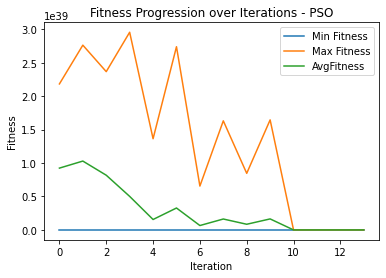

Min fitness: 72.02426013592981
Max fitness: 75.92381378534624
Avg fitness: 74.39566428628613
Std fitness: 1.0509766036835302
Best particle is [1720140430996361392928051980378356010176750494827814301950090150396780442904690688, 21091970087963441994844330942799183254457647402192475626007538023594003265486848, 20851487991786580675745973382708691786258275608035914105234584109207802676611, (1, 5742558252986517904484942081209796014154492421718439442633308935959258780189), 9975598199454183872262856493137388729019430915487175320242918921163918502833160192, 1], 75.92381378534624
p: 20851487991786580675745973382708691786258275608035914105234584109207802676611 

a: 1720140430996361392928051980378356010176750494827814301950090150396780442904690688

b: 21091970087963441994844330942799183254457647402192475626007538023594003265486848

G x: 1 

G v: 5742558252986517904484942081209796014154492421718439442633308935959258780189 n
n: 997559819945418387226285649313738872901943091548717532024291892116391850

In [128]:
def main():
    swarm = []
    SWARM_SIZE = 10
    MAX_ITERATIONS_WITHOUT_IMPROVEMENT = 10

    for _ in range(SWARM_SIZE):
        swarm.append(generate_curve())

    velocities = [[random.uniform(0, 1) for _ in range(6)] for _ in range(SWARM_SIZE)]

    best_positions = swarm.copy()
    best_fitnesses = [functionext.evaluate(particle)[0] for particle in swarm]

    global_best_index = np.argmax(best_fitnesses)
    global_best_position = best_positions[global_best_index]
    global_best_fitness = best_fitnesses[global_best_index]
    prev_best_fitness = -np.inf
    no_improvement_counter = 0

    min_fitnesses = []
    max_fitnesses = []
    avg_fitnesses = []

    for iteration in range(MAX_ITERATIONS):
        for i in range(SWARM_SIZE):
            particle = swarm[i]
            velocity = velocities[i]

            new_velocity = update_velocity(particle, velocity, best_positions[i], global_best_position, iteration,
                                           MAX_ITERATIONS)
            new_particle = update_position(particle, new_velocity)
            swarm[i] = new_particle
            velocities[i] = new_velocity
            fitness = functionext.evaluate(new_particle)[0]

            if fitness > best_fitnesses[i]:
                best_positions[i] = new_particle
                best_fitnesses[i] = fitness

            if fitness > global_best_fitness:
                global_best_position = new_particle
                global_best_fitness = fitness

        fitnesses = [functionext.evaluate(particle)[0] for particle in swarm]
        min_fitness = min(fitnesses)
        max_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        min_fitnesses.append(min_fitness)
        max_fitnesses.append(max_fitness)
        avg_fitnesses.append(avg_fitness)

        if global_best_fitness <= prev_best_fitness:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0
        if no_improvement_counter >= MAX_ITERATIONS_WITHOUT_IMPROVEMENT:
            print("No improvement in global best fitness for {} iterations. Stopping early.".format(
                MAX_ITERATIONS_WITHOUT_IMPROVEMENT))
            break
        prev_best_fitness = global_best_fitness

    plt.plot(min_fitnesses, label="Min Fitness")
    plt.plot(max_fitnesses, label="Max Fitness")
    plt.plot(avg_fitnesses, label="AvgFitness")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.title("Fitness Progression over Iterations - PSO")
    plt.legend()
    plt.show()

    std_fitness = np.std(fitnesses)
    print("Min fitness: %s" % min_fitness)
    print("Max fitness: %s" % max_fitness)
    print("Avg fitness: %s" % avg_fitness)
    print("Std fitness: %s" % std_fitness)

    best_particle_index = np.argmax(fitnesses)
    best_particle = swarm[best_particle_index]
    best_particle_fitness = fitnesses[best_particle_index]

    print("Best particle is %s, %s" % (best_particle, best_particle_fitness))
    print(f"p: {best_particle[2]} \n")
    print(f"a: {best_particle[0]}\n")
    print(f"b: {best_particle[1]}\n")
    print(f"G x: {best_particle[3][0]} \n")
    print(f"G v: {best_particle[3][1]} n")
    print(f"n: {best_particle[4]}\n")
    print(f"h:{best_particle[5]}\n")

    return best_particle

if __name__ == '__main__':
    best_particle = main()

In [133]:
p1=best_particle[2]
a1=best_particle[0]
b1=best_particle[1]
G_x1=best_particle[3][0]
G_y1=best_particle[3][1]
n1=best_particle[4]
h1=best_particle[5]

## **Proceso de encriptación y desencriptación**

1. Primero hay que seleccionar pseudoaleatoriamente los datos que se quieren encriptar, esto se hace seleccionando una fila aleatoria y cogiendo los 3 anteriores y los 3 posteriores. Después de esto se comparan si tienen el mismo OrdenNo y se encriptan las filas seleccionadas que contengan el mismo.

In [181]:
fila_aleatoria = np.random.randint(4, len(df) - 4)
fila_seleccionada = df.iloc[fila_aleatoria - 4: fila_aleatoria + 5]

In [182]:
fila_seleccionada_filtrada = fila_seleccionada[fila_seleccionada['OrderNo'] == fila_seleccionada.iloc[4]['OrderNo']]

In [245]:
fila_seleccionada_filtrada

,OrderNo,StockCode,Description,Quantity,OrderDate,UnitPrice,CustomerID
70348,542005,22386,JUMBO BAG PINK POLKADOT,10,2011-01-25 11:18:00,1.95,14409.0
70349,542005,85014B,RED RETROSPOT UMBRELLA,6,2011-01-25 11:18:00,5.95,14409.0
70350,542005,21936,RED RETROSPOT PICNIC BAG,10,2011-01-25 11:18:00,2.95,14409.0
70351,542005,21246,RED RETROSPOT BIG BOWL,6,2011-01-25 11:18:00,4.95,14409.0
70352,542005,20676,RED RETROSPOT BOWL,12,2011-01-25 11:18:00,1.25,14409.0
70353,542005,22740,POLKADOT PEN,144,2011-01-25 11:18:00,0.85,14409.0


2. Ahora se encriptan las filas con la curva elíptica.

Para el proceso de encriptación se necesitarán los siguientes parámetros:
- C1, C2
- encrypted_message
- private_key
- params

La siguiente función genera un número aleatorio en el rango [0, n).

In [235]:
def generate_ecc_parameters_and_private_key(best_ind):
    p, a, b, (G_x, G_y), n, h = best_ind[2], best_ind[0], best_ind[1], best_ind[3], best_ind[4], best_ind[5]
    ecc_params = functionext.ECCParameters(p, a, b, functionext.ECPoint(G_x, G_y), n, h)
    return functionext.generate_private_key(ecc_params)

private_keyGA = generate_ecc_parameters_and_private_key(best_ind)
private_keyPSO = generate_ecc_parameters_and_private_key(best_particle)
print("Clave privada generada:", private_keyGA)
print("Clave privada generada:", private_keyPSO)


Clave privada generada: 8277356664194624496521963840707277048372631678314368206162653633647952762825
Clave privada generada: 8739613863451268258295804980736963797390308909289692372461244688613935340722191547


In [236]:
def generate_public_key(private_key, p, a, b, G_x, G_y, n, h):
    # Punto base G
    G = functionext.ECPoint(G_x, G_y)

    # Parámetros de la curva
    params = functionext.ECCParameters(p, a, b, G, n, h)

    # Generación de la clave pública
    public_key = functionext.ec_scalar_multiplication(G, private_key, params)

    return public_key
public_keyGA = generate_public_key(private_keyGA, p, a, b, G_x, G_y, n, h)
public_keyPSO = generate_public_key(private_keyPSO, p1, a1, b1, G_x1, G_y1, n1, h1)

In [222]:
print(f"Public Key: ({public_keyGA.x}, {public_keyGA.y})")
print(f"Public Key: ({public_keyPSO.x}, {public_keyPSO.y})")

Public Key: (56614337665034830836455934755063490104785381021439132702695573715657278879608, 72911501500794006484606022319401354791488382891217367379429679095839777276724)
Public Key: (18507191397467181135513171600014289623162137659643978490979273030274574701008, 5753228988964427695639829958067206668101834083431549446245043878032831153120)


3. Posteriormente se desencriptan las filas.

In [237]:
def generate_C1_C2(public_key, ecc_params):
    # Generar un número aleatorio para usar como clave efímera
    k = randbelow(ecc_params.n - 1)

    # Inicializar los puntos C1 y C2
    C1 = functionext.ECPoint(None, None)

    # Multiplicación escalar para calcular C1 = k * G
    result = functionext.ECPoint(None, None)
    current = ecc_params.G
    while k:
        if k & 1:
            result = current if result.x is None else functionext.ec_addition(result, current, ecc_params)
        current = functionext.ec_addition(current, current, ecc_params)
        k >>= 1
    C1 = result

    # Generar un nuevo número aleatorio para k
    k = randbelow(ecc_params.n - 1)

    # Multiplicación escalar para calcular C2 = k * public_key
    result = functionext.ECPoint(None, None)
    current = public_key
    while k:
        if k & 1:
            result = current if result.x is None else functionext.ec_addition(result, current, ecc_params)
        current = functionext.ec_addition(current, current, ecc_params)
        k >>= 1
    C2 = result

    return C1, C2

ecc_paramsGA = functionext.ECCParameters(p, a, b, functionext.ECPoint(G_x, G_y), n, h)
C1GA, C2GA = generate_C1_C2(public_keyGA, ecc_paramsGA)
ecc_paramsPSO = functionext.ECCParameters(p1, a1, b1, functionext.ECPoint(G_x1, G_y1), n1, h1)
C1PSO, C2PSO = generate_C1_C2(public_keyPSO, ecc_paramsPSO)

In [224]:
print(C1GA.x)
print(C1GA.y)
print(C2GA.x)
print(C2GA.y)

109093360737779668729156614827417620804582525013041668995852098493234064148596
582828256806028723701596111245626440335179598704564541784428106895194767020
7600412421776839701736354205568287518072874107578278604315536496073713655473
32085530764030894206257020379028063506802061519037072806571224845262277685387


In [238]:
print(C1PSO.x)
print(C1PSO.y)
print(C2PSO.x)
print(C2PSO.y)

13876929156550899254199123070000552641469961127182193803057589632627727971144
10457056892097798350324630637135739430737505279842278142112144397845631982474
5189320817294219871579828449520282697139464283224756825306799793279937856571
8965086660259071682693128890850200006051536749605663436676772541652011399226


In [239]:
def encrypt_message(row, public_key, params, C1=None, C2=None):
    message_text = str(row)
    if C1 is None or C2 is None:
        k = functionext.generate_private_key(params)
        C1 = functionext.ec_scalar_multiplication(params.G, k, params)
        C2 = functionext.ec_scalar_multiplication(public_key, k, params)

    message_bytes = message_text.encode('utf-8')
    encrypted_message = []

    for byte in message_bytes:
        if C2.x is None:
            raise ValueError("Error de encriptación: kQ resultó en el punto en el infinito")
        encrypted_byte = byte ^ (C2.x & 0xFF)
        encrypted_message.append(encrypted_byte)

    return C1, C2, encrypted_message


def decrypt_message(C1, encrypted_message, private_key, params):
    try:
        C2 = functionext.ec_scalar_multiplication(C1, private_key, params)
    except Exception as e:
        print(f"Ocurrió un error durante la desencriptación: {str(e)}")
        return None

    decrypted_message_bytes = bytearray()

    for encrypted_byte in encrypted_message:
        if C2.x is None:
            raise ValueError("Error de desencriptación: C1 * clave privada resultó en el punto en el infinito")
        decrypted_byte = encrypted_byte ^ (C2.x & 0xFF)
        decrypted_message_bytes.append(decrypted_byte)

    possible_decodings = ['utf-8', 'latin-1', 'ascii']
    for encoding in possible_decodings:
        try:
            decrypted_message = decrypted_message_bytes.decode(encoding)
            return decrypted_message
        except UnicodeDecodeError:
            continue

    return None

El siguiente código que aparece a continuación ha sido realizado para poder iterar todas las filas seleccionadas.

In [227]:
def encrypt_messages(messages, public_key, ecc_params):
    encrypted_messages = []
    for _, row in messages.iterrows():
        message_dict = row.to_dict()
        C1, C2, encrypted_message = encrypt_message(message_dict, public_key, ecc_params)
        encrypted_messages.append((C1, encrypted_message))
    return encrypted_messages


def decrypt_messages(encrypted_messages, private_key, params):
    decrypted_messages = []
    for C1, encrypted_message in encrypted_messages:
        decrypted_message = decrypt_message(C1, encrypted_message, private_key, params)
        decrypted_messages.append(decrypted_message)
    return decrypted_messages

In [228]:
messages=fila_seleccionada_filtrada
encrypted_messagesGA = encrypt_messages(messages, public_keyGA, ecc_paramsGA)
decrypted_messagesGA = decrypt_messages(encrypted_messagesGA, private_keyGA, ecc_paramsGA)

encrypted_messagesPSO = encrypt_messages(messages, public_keyPSO, ecc_paramsPSO)
decrypted_messagesPSO = decrypt_messages(encrypted_messagesPSO, private_keyPSO, ecc_paramsPSO)

In [246]:
print("Mensaje encriptado GA")
print(encrypted_messagesGA)
print("Mensaje encriptado PSO")
print(encrypted_messagesPSO)

Mensaje encriptado GA
[(<functionext.ECPoint object at 0x7fe093032400>, [229, 185, 209, 236, 250, 251, 236, 208, 241, 185, 164, 190, 171, 170, 172, 174, 174, 171, 178, 190, 185, 205, 234, 241, 253, 245, 221, 241, 250, 251, 185, 164, 190, 172, 172, 173, 166, 168, 178, 190, 185, 218, 251, 237, 253, 236, 247, 238, 234, 247, 241, 240, 185, 164, 190, 185, 212, 203, 211, 220, 209, 190, 220, 223, 217, 190, 206, 215, 208, 213, 190, 206, 209, 210, 213, 223, 218, 209, 202, 185, 178, 190, 185, 207, 235, 255, 240, 234, 247, 234, 231, 185, 164, 190, 175, 174, 178, 190, 185, 209, 236, 250, 251, 236, 218, 255, 234, 251, 185, 164, 190, 202, 247, 243, 251, 237, 234, 255, 243, 238, 182, 185, 172, 174, 175, 175, 179, 174, 175, 179, 172, 171, 190, 175, 175, 164, 175, 166, 164, 174, 174, 185, 183, 178, 190, 185, 203, 240, 247, 234, 206, 236, 247, 253, 251, 185, 164, 190, 175, 176, 167, 171, 178, 190, 185, 221, 235, 237, 234, 241, 243, 251, 236, 215, 218, 185, 164, 190, 175, 170, 170, 174, 167, 176, 174, 22

In [230]:
for i in decrypted_messagesGA:
  print(i)

{'OrderNo': 542005, 'StockCode': 22386, 'Description': 'JUMBO BAG PINK POLKADOT', 'Quantity': 10, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 1.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': '85014B', 'Description': 'RED RETROSPOT UMBRELLA', 'Quantity': 6, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 5.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 21936, 'Description': 'RED RETROSPOT PICNIC BAG', 'Quantity': 10, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 2.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 21246, 'Description': 'RED RETROSPOT BIG BOWL', 'Quantity': 6, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 4.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 20676, 'Description': 'RED RETROSPOT BOWL', 'Quantity': 12, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 1.25, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 22740, 'Description': 'POLKADOT PEN',

In [231]:
for i in decrypted_messagesPSO:
  print(i)

{'OrderNo': 542005, 'StockCode': 22386, 'Description': 'JUMBO BAG PINK POLKADOT', 'Quantity': 10, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 1.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': '85014B', 'Description': 'RED RETROSPOT UMBRELLA', 'Quantity': 6, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 5.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 21936, 'Description': 'RED RETROSPOT PICNIC BAG', 'Quantity': 10, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 2.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 21246, 'Description': 'RED RETROSPOT BIG BOWL', 'Quantity': 6, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 4.95, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 20676, 'Description': 'RED RETROSPOT BOWL', 'Quantity': 12, 'OrderDate': Timestamp('2011-01-25 11:18:00'), 'UnitPrice': 1.25, 'CustomerID': 14409.0}
{'OrderNo': 542005, 'StockCode': 22740, 'Description': 'POLKADOT PEN',

## **Ataques y pruebas**

Por último hay que comprobar con un algoritmo externo cuánto se tarda en desencriptarlo.

In [232]:
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

Se ha probado a atacar el proceso criptográfico con el algoritmo rho_pollard casi un total de 48h sin resultado, por lo cual se puede observar que la encriptación es segura para este ataque.

La función que se define a continuación es el algoritmo de factorización rho_pollard toma como entrada el mensaje encriptado (encrypted_message), la clave pública (public_key) y los parámetros de la curva elíptica (params).

1. Se han extraido los valores necesarios de la clave pública y los parámetros de la curva elíptica: el primer componente de la clave pública (alpha), el segundo componente de la clave pública (beta), y el valor de p de los parámetros de la curva elíptica (params.p).
2. Se han inicializado las variables x e y con el valor 2, y d con el valor 1.
3. Se ha ejecutado un bucle while hasta que d no sea igual a 1. En cada iteración del bucle, se actualizan los valores de x e y utilizando la función de recurrencia específica del algoritmo de Rho de Pollard.
4. Después de salir del bucle, se verifica si d es igual a p. Si es así, significa que el algoritmo no pudo factorizar p y se genera una excepción.
5. Finalmente, se devuelve la tupla (d, p // d), donde d es el factor primo encontrado y p // d es el otro factor primo.

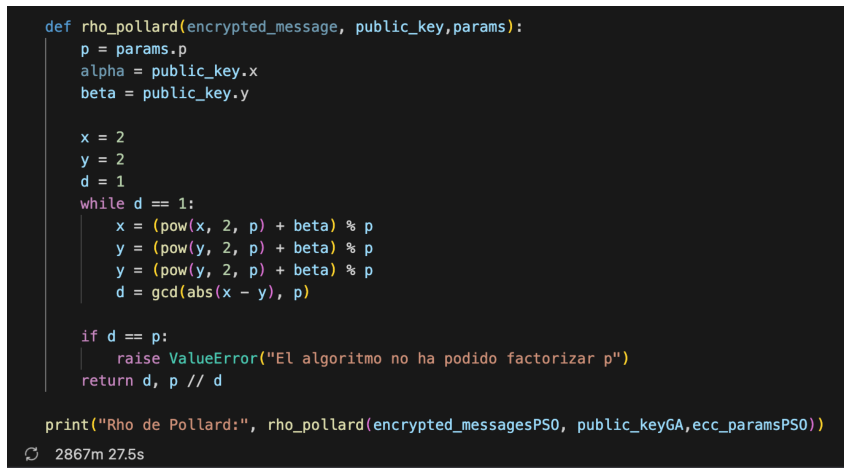

In [113]:
'''
def rho_pollard(encrypted_message, public_key,params):
    p = params.p
    alpha = public_key.x
    beta = public_key.y

    x = 2
    y = 2
    d = 1
    while d == 1:
        x = (pow(x, 2, p) + beta) % p
        y = (pow(y, 2, p) + beta) % p
        y = (pow(y, 2, p) + beta) % p
        d = gcd(abs(x - y), p)
      
    if d == p:
        raise ValueError("El algoritmo no ha podido factorizar p")
    return d, p // d

print("Rho de Pollard:", rho_pollard(encrypted_messagesPSO, public_keyGA,ecc_paramsPSO))
'''

ruta_imagen = 'rho_pollard.png'
imagen = mpimg.imread(ruta_imagen)

plt.figure(figsize=(15, 10))  
plt.imshow(imagen)
plt.axis('off')
plt.show()


Se ha probado también por fuerza bruta y se ha obtenido el mismo resultado que en el caso anterior.

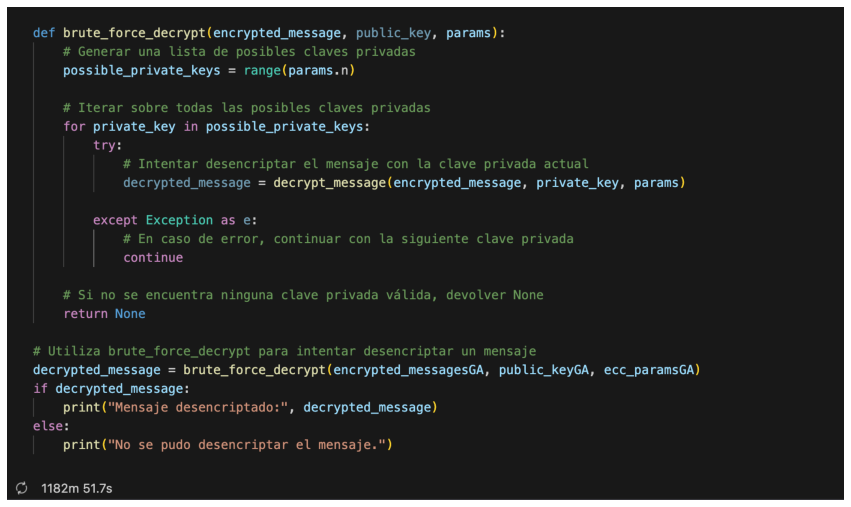

In [117]:
'''
def brute_force_decrypt(encrypted_message, public_key, params):
    # Generar una lista de posibles claves privadas
    possible_private_keys = range(params.n)

    # Iterar sobre todas las posibles claves privadas
    for private_key in possible_private_keys:
        try:
            # Intentar desencriptar el mensaje con la clave privada actual
            decrypted_message = decrypt_message(encrypted_message, private_key, params)

        except Exception as e:
            # En caso de error, continuar con la siguiente clave privada
            continue

    # Si no se encuentra ninguna clave privada válida, devolver None
    return None

# Utiliza brute_force_decrypt para intentar desencriptar un mensaje
decrypted_message = brute_force_decrypt(encrypted_messagesGA, public_keyGA, ecc_paramsGA)
if decrypted_message:
    print("Mensaje desencriptado:", decrypted_message)
else:
    print("No se pudo desencriptar el mensaje.")
'''

ruta_imagen = 'fuerzabruta.png'
imagen = mpimg.imread(ruta_imagen)

plt.figure(figsize=(15, 10))  
plt.imshow(imagen)
plt.axis('off')
plt.show()


Por último, se han realizado algunas comprobaciones estadísticas para probar que los datos son buenos para nuestro proyecto.

Al comparar los factores primos obtenidos de diferentes claves públicas generadas con diferentes parámetros, se evalua la "fortaleza" de cada conjunto de parámetros en términos de su capacidad para resistir ataques de factorización. Este análisis es crucial para determinar qué configuración de parámetros produce claves públicas más seguras, lo que a su vez puede aumentar la robustez y la seguridad de un sistema criptográfico. Estas evaluaciones son esenciales para la investigación en criptografía y seguridad informática, ya que permiten identificar y recomendar las mejores prácticas en la generación de claves para garantizar la confidencialidad e integridad de la información sensible.

In [240]:
def ecm_factor(n):
    factors = factorint(n)
    return factors

factores = ecm_factor(public_keyGA.x)
factores2 = ecm_factor(public_keyPSO.x)

factores3 = ecm_factor(public_keyGA.y)
factores4 = ecm_factor(public_keyPSO.y)
print("Factores primos de", public_keyGA.x, "son:", factores)
print("Factores primos de", public_keyGA.y, "son:", factores3)

print("Factores primos de", public_keyPSO.x, "son:", factores2)
print("Factores primos de", public_keyPSO.y, "son:", factores4)


Factores primos de 83061773861971730963633673533918581648002757299144772755677625088060392365216 son: {2: 5, 7: 2, 52973070065032991685990863223162360744899717665270900992141342530650760437: 1}
Factores primos de 11484637545135274022975969654634463715714367679121426190097798721595052825686 son: {2: 1, 3: 2, 17: 1, 73: 1, 47581: 1, 2482619: 1, 1344844981699: 1, 3253813034449277: 1, 994636850448279248224539033491651: 1}
Factores primos de 14749683340622490822548290618099482261939211851829419234980885448014970341282 son: {2: 1, 17: 1, 24977: 1, 53149: 1, 326789736399751215232358029488298361950191907059732044654971860901: 1}
Factores primos de 17604275752801823324500614953762198435309589398186523855327361143457269301477 son: {13: 1, 1657: 1, 718805539: 1, 188889525397: 1, 6019120136237380593652546754452695982971059034913759: 1}


Para comparar la aleatoriedad de los factores primos obtenidos con Python, se han utiliado algunas métricas estadísticas para evaluar la distribución y la aparente de la aleatoriedad de los números primos. Aquí hay algunas ideas sobre cómo podrías hacerlo:

1. **Longitud de los factores primos**: La longitud de los factores primos puede ser una indicación de su aleatoriedad. En general, los números primos más largos tienden a ser más aleatorios. Puedes calcular la longitud de los factores primos utilizando la función `len()` en Python.


In [241]:
longitud_factores = [len(str(numero)) for numero in factores.keys()]

In [242]:
longitud_factores

[1, 1, 74]

2. **Prueba de distribución uniforme**: Se ha calculado la frecuencia de cada dígito en los factores primos y se ha comparado con una distribución uniforme esperada. Hay 10 dígitos posibles por tanto 10-1=9 grados de libertad.

Para factores:
chi cuadrado 9.0
frecuencia esperada 7.6


Para factores2:
chi cuadrado 5.9367088607594924
frecuencia esperada 7.9


Para factores3:
chi cuadrado 13.75
frecuencia esperada 8.0


Para factores4:
chi cuadrado 8.21518987341772
frecuencia esperada 7.9


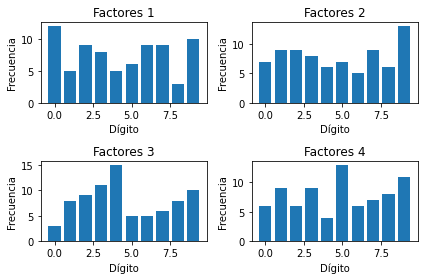

In [243]:
digitos = [int(d) for primo in factores for d in str(primo)]
frecuencia_digitos = Counter(digitos)

digitos2 = [int(d) for primo in factores2 for d in str(primo)]
frecuencia_digitos2 = Counter(digitos2)

digitos3 = [int(d) for primo in factores3 for d in str(primo)]
frecuencia_digitos3 = Counter(digitos3)

digitos4 = [int(d) for primo in factores4 for d in str(primo)]
frecuencia_digitos4 = Counter(digitos4)

# Calcular la frecuencia esperada en una distribución uniforme
# Hay 10 dígitos posibles (0-9) en una distribución uniforme
total_digitos = sum(frecuencia_digitos.values())
frecuencia_esperada = total_digitos / 10  

total_digitos2 = sum(frecuencia_digitos2.values())
frecuencia_esperada2 = total_digitos2 / 10  

total_digitos3 = sum(frecuencia_digitos3.values())
frecuencia_esperada3 = total_digitos3 / 10  

total_digitos4 = sum(frecuencia_digitos4.values())
frecuencia_esperada4 = total_digitos4 / 10  


# Calcular la chi-cuadrado
chi_cuadrado = sum((frecuencia - frecuencia_esperada) ** 2 / frecuencia_esperada for frecuencia in frecuencia_digitos.values())
print("Para factores:")
print("chi cuadrado",chi_cuadrado)
print("frecuencia esperada",frecuencia_esperada)
print("\n")

chi_cuadrado2 = sum((frecuencia2 - frecuencia_esperada2) ** 2 / frecuencia_esperada2 for frecuencia2 in frecuencia_digitos2.values())
print("Para factores2:")
print("chi cuadrado",chi_cuadrado2)
print("frecuencia esperada",frecuencia_esperada2)
print("\n")

chi_cuadrado3 = sum((frecuencia3 - frecuencia_esperada3) ** 2 / frecuencia_esperada3 for frecuencia3 in frecuencia_digitos3.values())
print("Para factores3:")
print("chi cuadrado",chi_cuadrado3)
print("frecuencia esperada",frecuencia_esperada3)
print("\n")

chi_cuadrado4 = sum((frecuencia4 - frecuencia_esperada4) ** 2 / frecuencia_esperada4 for frecuencia4 in frecuencia_digitos4.values())
print("Para factores4:")
print("chi cuadrado",chi_cuadrado4)
print("frecuencia esperada",frecuencia_esperada4)


fig, axs = plt.subplots(2, 2)

axs[0, 0].bar(frecuencia_digitos.keys(), frecuencia_digitos.values())
axs[0, 0].set_title('Factores 1')

axs[0, 1].bar(frecuencia_digitos2.keys(), frecuencia_digitos2.values())
axs[0, 1].set_title('Factores 2')

axs[1, 0].bar(frecuencia_digitos3.keys(), frecuencia_digitos3.values())
axs[1, 0].set_title('Factores 3')

axs[1, 1].bar(frecuencia_digitos4.keys(), frecuencia_digitos4.values())
axs[1, 1].set_title('Factores 4')

for ax in axs.flat:
    ax.set(xlabel='Dígito', ylabel='Frecuencia')

plt.tight_layout()
plt.show()


- Usando un nivel de significancia del 5%, el valor crítico de la distribución chi-cuadrado para 1 grado de libertad es aproximadamente 3.84. Dado que el valor de chi-cuadrado calculado es mayor que el valor crítico, hay suficiente evidencia para rechazar la hipótesis nula de que la distribución observada sigue una distribución uniforme. En otras palabras, existe una discrepancia significativa entre la distribución observada y la distribución esperada a un nivel de significancia del 5%.

- Usando un nivel de significancia del 5%, el valor crítico de la distribución chi-cuadrado para 1 grado de libertad es aproximadamente 3.84. Dado que el valor de chi-cuadrado calculado es menor que el valor crítico, no hay suficiente evidencia para rechazar la hipótesis nula de que la distribución observada sigue una distribución uniforme. En otras palabras, no hay una discrepancia significativa entre la distribución observada y la distribución esperada a un nivel de significancia del 5%.

- Usando un nivel de significancia del 5%, el valor crítico de la distribución chi-cuadrado para 1 grado de libertad es aproximadamente 3.84. Dado que el valor de chi-cuadrado calculado es mayor que el valor crítico, hay suficiente evidencia para rechazar la hipótesis nula de que la distribución observada sigue una distribución uniforme. En otras palabras, existe una discrepancia significativa entre la distribución observada y la distribución esperada a un nivel de significancia del 5%.

- Usando un nivel de significancia del 5%, el valor crítico de la distribución chi-cuadrado para 1 grado de libertad es aproximadamente 3.84. Dado que el valor de chi-cuadrado calculado es mayor que el valor crítico, hay suficiente evidencia para rechazar la hipótesis nula de que la distribución observada sigue una distribución uniforme. En otras palabras, existe una discrepancia significativa entre la distribución observada y la distribución esperada a un nivel de significancia del 5%.


Para calcular la entropía de una distribución de probabilidad, se ha utilizado la fórmula de la entropía de Shannon y se han obtenido los siguientes resultados:

- ULa entropía es baja (1.298), lo que indica que hay poco desorden o incertidumbre en el conjunto de datos.
- La entropía es moderada (2.322), lo que sugiere un nivel medio de desorden o incertidumbre.
- La entropía es alta (3.122), lo que indica un alto nivel de desorden o incertidumbre en los datos.
-  La entropía es moderada (2.322), similar al caso 2.

In [244]:
def calcular_entropia(factores_frecuencia):
    total = sum(factores_frecuencia.values())
    entropia = 0
    for frecuencia in factores_frecuencia.values():
        probabilidad = frecuencia / total
        entropia -= probabilidad * math.log2(probabilidad)
    return entropia

entropia = calcular_entropia(factores)
entropia2 = calcular_entropia(factores2)
entropia3 = calcular_entropia(factores3)
entropia4 = calcular_entropia(factores4)
print("Entropía:", entropia)
print("Entropía:", entropia2)
print("Entropía:", entropia3)
print("Entropía:", entropia4)

Entropía: 1.2987949406953985
Entropía: 2.321928094887362
Entropía: 3.121928094887362
Entropía: 2.321928094887362
